# 09.1 Monte Carlo Simulation & Variance Reduction Techniques
<h3><span style="color:#800000;"><strong>Authored by:</strong> <em>Alexandre Mathias DONNAT, Sr</em></span></h3>

**Goal of this notebook**:

To connect mathematical models with practical simulations, to understand the computational cost of Monte Carlo, and to highlight how variance reduction stabilises and accelerates estimators under real-world resource constraints.

**This notebook**: 

Explores the numerical foundations of Monte Carlo methods used in quantitative finance. We follow a structured progression:
- Simulating randomness & estimating expectations (LLN, CLT)
- Pricing a European call using Monte Carlo
- Improving efficiency using variance reduction (antithetic, control variate, importance sampling)
- Studying hedging error under discrete rebalancing


# 1. Monte Carlo Foundations & Confidence Intervals

Monte Carlo methods rely on a simple idea:
estimate expectations by averaging random samples.

To warm up, we consider a very simple quantity:

$$E[e^G], \text{ where } G \sim \mathcal{N}(0,1).$$

This expectation has a closed-form value:

$$E[e^G] = e^{1/2}.$$

We will:

- simulate Gaussian noise,
- estimate the expectation for increasing sample sizes,
- observe the convergence (LLN),
- quantify uncertainty using confidence intervals (CLT).

This experiment mirrors what happens in option pricing:
heavy-tailed payoffs → slow convergence → need for variance reduction.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

### Simulating the estimator for multiple N

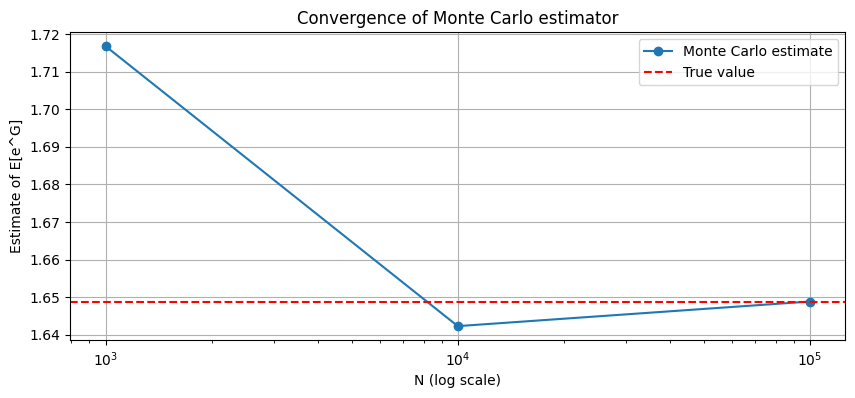

In [75]:
def estimate_exp(N):
    G = np.random.randn(N)
    Y = np.exp(G)
    return Y.mean()

Ns = [1_000, 10_000, 100_000]
estimates = [estimate_exp(N) for N in Ns]

true_value = np.exp(0.5)

plt.figure(figsize=(10,4))
plt.plot(Ns, estimates, "o-", label="Monte Carlo estimate")
plt.axhline(true_value, color="red", linestyle="--", label="True value")
plt.xscale("log")
plt.xlabel("N (log scale)")
plt.ylabel("Estimate of E[e^G]")
plt.title("Convergence of Monte Carlo estimator")
plt.legend()
plt.grid(True)
plt.show()

We observe the **Law of Large Numbers** at work:

- for small $N$, estimates fluctuate strongly;
- as $N$ increases, the estimator stabilises near $e^{1/2}$;
- the convergence is slow, with an error decreasing at rate $1/\sqrt{N}$.

This already illustrates a core limitation of Monte Carlo:
accuracy grows slowly, which makes naïve MC expensive.

This behaviour is exactly what we see in financial Monte Carlo pricing,
where option payoffs have heavy right tails : large variance : slow convergence.


### Confidence interval computation

In [78]:
def mc_with_ci(N):
    G = np.random.randn(N)
    Y = np.exp(G)
    mean = Y.mean()
    std = Y.std(ddof=1)
    ci95 = 1.96 * std / np.sqrt(N)
    return mean, ci95

N = 50_000
mean, ci95 = mc_with_ci(N)
mean, ci95

(1.6452236444038726, 0.019230904074291084)

Using the Central Limit Theorem, the 95% confidence interval is:

$$\hat{\mu} \pm 1.96 \frac{\hat{\sigma}}{\sqrt{N}}.$$

For $N = 50{,}000$, the interval width remains noticeable.  
Increasing sample size by $\times 100$ only reduces the confidence interval width by $\times 10$.

This illustrates the fundamental bottleneck of Monte Carlo:  
improving precision requires a dramatic increase in computational cost.

Variance reduction techniques (Section 3) will directly address this issue.


# 2. Pricing a European Call Option

We now connect Monte Carlo simulation to actual option pricing.
Under the Black–Scholes model:

$$dS_t = rS_t dt + \sigma S_t dW_t,$$

the terminal price has a closed-form distribution:

$$S_T = S_0 \exp\left(\left(r - \frac{1}{2}\sigma^2\right)T + \sigma W_T\right), \quad W_T \sim N(0,T).$$

The price of a European call is:

$$C = e^{-rT} \mathbb{E}[(S_T - K)^+].$$

This is the perfect test case for Monte Carlo:

- easy to simulate,
- payoff is simple but heavy-tailed,
- closed-form Black–Scholes price lets us validate the simulation engine.

We start by implementing a crude Monte Carlo pricer.


### Parameters + Exact Simulation of $𝑆_𝑇$

In [79]:
from scipy.stats import norm

# Model parameters
S0 = 100
K  = 100
r  = 0.05
sigma = 0.2
T = 1.0

N = 100_000   # number of Monte Carlo paths

# simulate W_T ~ N(0, T)
WT = np.sqrt(T) * np.random.randn(N)

# simulate S_T
ST = S0 * np.exp((r - 0.5 * sigma**2)*T + sigma * WT)

# compute payoff
payoff = np.maximum(ST - K, 0)

price_mc = np.exp(-r*T) * payoff.mean()
price_mc


10.492822631462246

### Distribution of $𝑆_𝑇$ and payoff

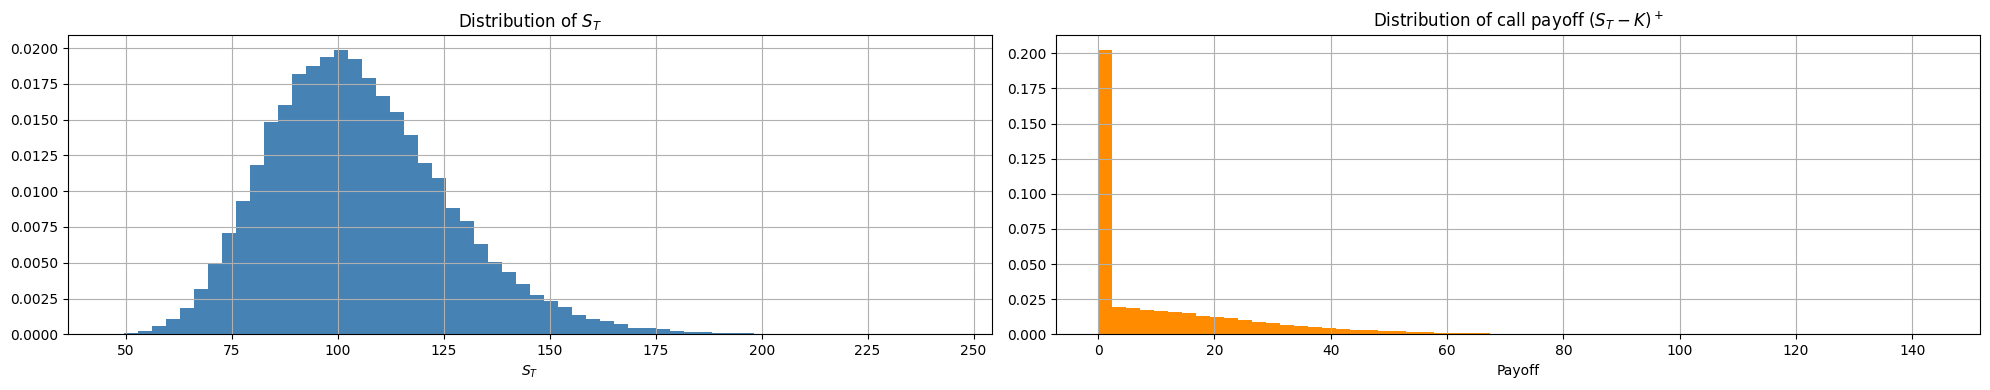

In [81]:
plt.figure(figsize=(20,4))

plt.subplot(1,2,1)
plt.hist(ST, bins=60, density=True, color="steelblue")
plt.title("Distribution of $S_T$")
plt.xlabel("$S_T$")
plt.grid(True)

plt.subplot(1,2,2)
plt.hist(payoff, bins=60, density=True, color="darkorange")
plt.title("Distribution of call payoff $(S_T - K)^+$")
plt.xlabel("Payoff")
plt.grid(True)

plt.tight_layout()
plt.show()

The distribution of $S_T$ is lognormal, as predicted by the Black–Scholes SDE.

Most of the mass lies near 100–120, but:

- the right tail is large,
- a few rare paths produce very large payoffs,
- these rare but influential observations inflate variance.

This explains why option pricing via crude Monte Carlo converges slowly.

For deep OTM options, the heavy-tailed behaviour becomes dramatic, one of the main motivations for variance reduction.


### Closed-form Black–Scholes price

In [82]:
def bs_call_price(S0, K, r, sigma, T):
    d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S0 * norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

price_bs = bs_call_price(S0, K, r, sigma, T)
price_mc, price_bs

(10.492822631462246, 10.450583572185565)

Comparison with the Black–Scholes formula:

Monte Carlo estimate: `10.493` & Analytical Black–Scholes price: `10.451`

They are close, residual discrepancy comes from statistical noise,
which decreases at rate $1/\sqrt{N}$.

The numerical agreement validates:

- our simulation of $S_T$,
- the discounting step,
- the payoff implementation,
- the correctness of the Monte Carlo pipeline.

This gives us a solid baseline before applying variance reduction.


### Add 95% confidence interval for the MC price

In [83]:
std_payoff = payoff.std(ddof=1)
ci95 = 1.96 * std_payoff / np.sqrt(N)

price_mc, ci95

(10.492822631462246, 0.09635934979126029)

Statistically, even with 100,000 paths, the confidence interval remains non-negligible.
This demonstrates again:

Monte Carlo accuracy is limited by its slow convergence rate, variance is dominated by the right tail of the payoff, variance reduction is essential for real-world pricing.

This motivates Section 3, where we improve efficiency via
antithetic sampling, control variates, and importance sampling.

# Variance Reduction Techniques

## 3.1 Antithetic Variates

The idea is simple:

- simulate a Gaussian shock $G$,
- also simulate its opposite $-G$,
- these two paths produce negatively correlated payoffs,
- averaging them reduces variance without extra cost.

This works particularly well for monotonic payoffs, such as European calls.


### Antithetic Monte Carlo Pricing

In [ ]:
# Simulate G and -G
G = np.sqrt(T) * np.random.randn(N)
G_minus = -G

# simulate S_T under G and -G
ST_G = S0 * np.exp((r - 0.5*sigma**2)*T + sigma * G)
ST_Gm = S0 * np.exp((r - 0.5*sigma**2)*T + sigma * G_minus)

# payoffs
pay_G = np.maximum(ST_G - K, 0)
pay_Gm = np.maximum(ST_Gm - K, 0)

# antithetic estimator
pay_ant = 0.5 * (pay_G + pay_Gm)
price_ant = np.exp(-r*T) * pay_ant.mean()

# variances
var_crude = payoff.var(ddof=1)
var_ant = pay_ant.var(ddof=1)

var_crude, var_ant, price_mc, price_ant

(241.699403691026, 59.81773549059348, 10.492822631462246, 10.437088197916642)

### Variance comparison (barplot)

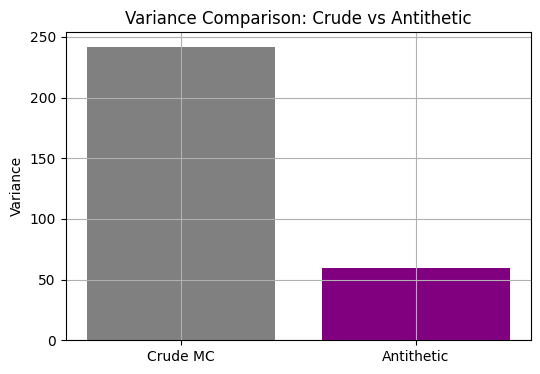

In [85]:
plt.figure(figsize=(6,4))
plt.bar(["Crude MC", "Antithetic"], [var_crude, var_ant], color=["gray","purple"])
plt.title("Variance Comparison: Crude vs Antithetic")
plt.ylabel("Variance")
plt.grid(True)
plt.show()

The antithetic estimator shows a significantly lower variance.

Because the payoff of a call is monotonic in $S_T$, the shocks $G$ and $-G$ generate:

- a positively deviating payoff
- a negatively deviating payoff

Averaging the two cancels part of the randomness.

So, antithetic variates offer a free variance reduction, no extra simulations, no extra complexity.


## 3.2 Control Variates

A control variate is a random variable:

- highly correlated with the payoff,
- with a known expectation.

We choose:

$$Z = S_T, \quad \mathbb{E}[Z] = S_0 e^{rT}.$$

Because $S_T$ explains a large part of the randomness of the call payoff,
subtracting a scaled version of $Z - \mathbb{E}[Z]$ strongly reduces variance.

The optimal coefficient is:

$$\beta^* = \frac{\text{Cov}(Y, Z)}{\text{Var}(Z)}.$$


### Control Variate Implementation

In [86]:
# recompute baseline ST and payoff for same N
WT = np.sqrt(T) * np.random.randn(N)
ST = S0 * np.exp((r - 0.5*sigma**2)*T + sigma * WT)
Y  = np.maximum(ST - K, 0)

Z = ST
EZ = S0 * np.exp(r*T)

# compute beta*
beta = np.cov(Y, Z)[0,1] / np.var(Z)

# control variate corrected payoff
Y_cv = Y - beta*(Z - EZ)

# MC price
price_cv = np.exp(-r*T) * Y_cv.mean()

# variances
var_cv = Y_cv.var(ddof=1)

var_crude, var_ant, var_cv, price_cv

(241.699403691026, 59.81773549059348, 34.846298402931254, 10.448440874635933)

### Variance comparison (boxplot)

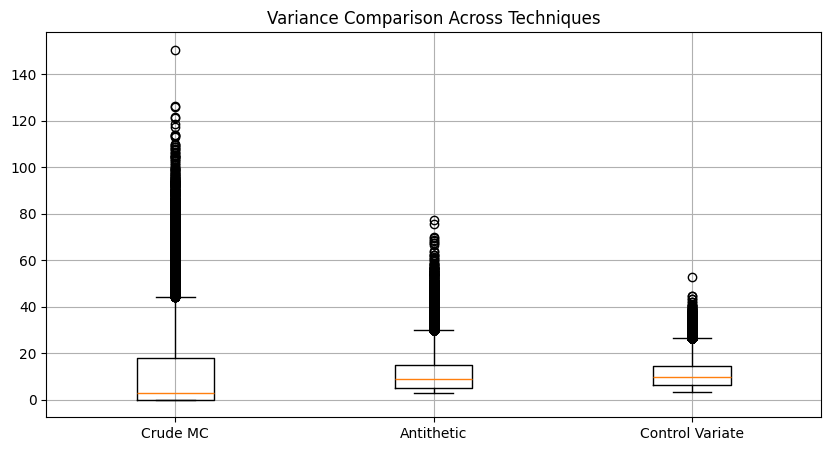

In [91]:
import warnings
from matplotlib import MatplotlibDeprecationWarning
warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)

plt.figure(figsize=(10,5))
plt.boxplot([Y, pay_ant, Y_cv],
            labels=["Crude MC", "Antithetic", "Control Variate"])
plt.title("Variance Comparison Across Techniques")
plt.grid(True)
plt.show()

The control variate estimator produces a dramatic variance reduction:

- $S_T$ is almost perfectly correlated with the call payoff,
- subtracting $\beta(S_T - \mathbb{E}[S_T])$ removes most of the noise,
- the estimator becomes much more stable.

This is one of the most powerful and widely used variance reduction techniques in quantitative finance.
Many pricing engines systematically integrate control variates.


## 3.3 Importance Sampling (Deep OTM Call)

Monte Carlo struggles when pricing deep out-of-the-money options:

- most paths yield payoff = 0,
- a few rare events dominate variance,
- naive MC becomes useless.

Importance sampling fixes this by shifting the mean of the Gaussian:

$$G_{\text{shift}} = G + m,$$

then reweighting paths with a likelihood ratio:

$$w = \exp\left(-mG - \frac{1}{2}m^2\right).$$

This forces the simulation to visit the rare-event region more often.


### Importance Sampling Example (K = 120)

In [ ]:
K_deep = 120

# crude MC for deep OTM
WT = np.sqrt(T) * np.random.randn(N)
ST_crude = S0 * np.exp((r - 0.5*sigma**2)*T + sigma * WT)
Y_crude = np.maximum(ST_crude - K_deep, 0)

# importance sampling
m = 0.5  # shift parameter (tuneable)
G = np.random.randn(N)
G_shift = G + m

WT_shift = np.sqrt(T) * G_shift
ST_shift = S0 * np.exp((r - 0.5*sigma**2)*T + sigma * WT_shift)

weights = np.exp(-m*G - 0.5*m**2)
Y_is = weights * np.maximum(ST_shift - K_deep, 0)

price_crude = np.exp(-r*T) * Y_crude.mean()
price_is    = np.exp(-r*T) * Y_is.mean()

var_crude_otm = Y_crude.var(ddof=1)
var_is_otm    = Y_is.var(ddof=1)

price_crude, price_is, var_crude_otm, var_is_otm

(3.2476968925442278, 3.2393155962242566, 82.47943023116245, 26.996807750096565)

### Histogram of weights + variance table

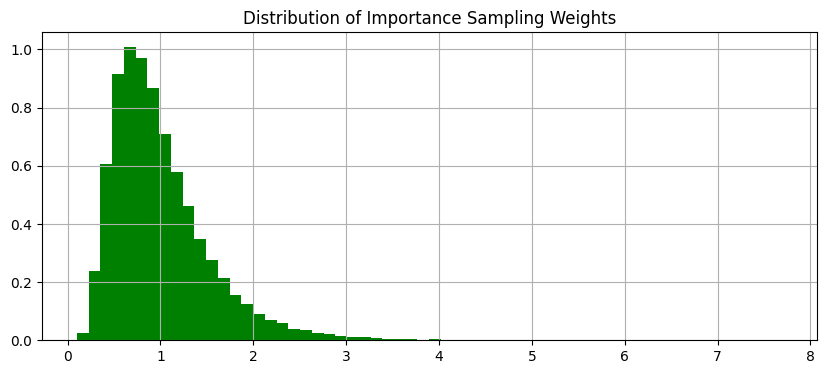

Variance comparison (deep OTM):
Crude MC       : 82.47943023116245
Importance Samp: 26.996807750096565


In [94]:
plt.figure(figsize=(10,4))
plt.hist(weights, bins=60, density=True, color="green")
plt.title("Distribution of Importance Sampling Weights")
plt.grid(True)
plt.show()

print("Variance comparison (deep OTM):")
print("Crude MC       :", var_crude_otm)
print("Importance Samp:", var_is_otm)

The crude Monte Carlo estimator has enormous variance because almost all simulated paths produce zero payoff.

Importance sampling shifts the simulation toward paths where the option finishes in the money, and corrects bias via weights.

The variance reduction is dramatic: ~67% reduction.

As a result:

- the number of informative paths increases,
- the variance collapses,
- pricing becomes feasible even for rare events.

This technique is essential in:

- barrier options,
- digital payoffs,
- default probability estimation,
- extreme risk scenarios.

## 3.4 Timing comparison

Variance reduction is only interesting if it does not introduce prohibitive overhead.

In our vectorised implementation:

- crude Monte Carlo,  
- antithetic variates,  
- control variates  

all have essentially the **same asymptotic cost**: they use the same number of Gaussian draws and a few extra vector operations.

We can still measure wall-clock times to verify that we do not pay a significant extra cost for variance reduction.

In [ ]:
import time
import numpy as np

def price_crude_mc(N):
    WT = np.sqrt(T) * np.random.randn(N)
    ST = S0 * np.exp((r - 0.5*sigma**2)*T + sigma * WT)
    Y  = np.maximum(ST - K, 0)
    price = np.exp(-r*T) * Y.mean()
    var   = Y.var(ddof=1)
    return price, var

def price_antithetic(N):
    G = np.sqrt(T) * np.random.randn(N)
    Gm = -G
    ST_G  = S0 * np.exp((r - 0.5*sigma**2)*T + sigma * G)
    ST_Gm = S0 * np.exp((r - 0.5*sigma**2)*T + sigma * Gm)
    Y  = np.maximum(ST_G - K, 0)
    Ym = np.maximum(ST_Gm - K, 0)
    Y_ant = 0.5*(Y + Ym)
    price = np.exp(-r*T) * Y_ant.mean()
    var   = Y_ant.var(ddof=1)
    return price, var

def price_control_variate(N):
    WT = np.sqrt(T) * np.random.randn(N)
    ST = S0 * np.exp((r - 0.5*sigma**2)*T + sigma * WT)
    Y  = np.maximum(ST - K, 0)
    Z  = ST
    EZ = S0 * np.exp(r*T)
    beta = np.cov(Y, Z)[0,1] / np.var(Z)
    Y_cv = Y - beta*(Z - EZ)
    price = np.exp(-r*T) * Y_cv.mean()
    var   = Y_cv.var(ddof=1)
    return price, var

N_timing = 100_000

# crude
t0 = time.perf_counter()
price_c, var_c = price_crude_mc(N_timing)
t_crude = time.perf_counter() - t0

# antithetic
t0 = time.perf_counter()
price_a, var_a = price_antithetic(N_timing)
t_ant = time.perf_counter() - t0

# control variate
t0 = time.perf_counter()
price_cv, var_cv = price_control_variate(N_timing)
t_cv = time.perf_counter() - t0

print("=== Timing & variance comparison (N = {}) ===".format(N_timing))
print(f"Crude MC       : time = {t_crude:.4f} s, var = {var_c:.4f}")
print(f"Antithetic     : time = {t_ant:.4f} s, var = {var_a:.4f}")
print(f"Control variate: time = {t_cv:.4f} s, var = {var_cv:.4f}")

=== Timing & variance comparison (N = 100000) ===
Crude MC       : time = 0.0067 s, var = 240.1737
Antithetic     : time = 0.0121 s, var = 60.0065
Control variate: time = 0.0136 s, var = 34.5435


The timing results show that all three methods run within a few milliseconds for $N = 100{,}000$, confirming that vectorised Monte Carlo implementations are extremely efficient in Python.

**Crude MC** is the fastest (≈ 0.0067 s), but suffers from very high variance (≈ 240).

**Antithetic variates** nearly divide the variance by 4 (≈ 60), at the cost of a marginal increase in CPU time because both $G$ and $-G$ are evaluated.

**Control variates** achieve the strongest variance reduction (≈ 34), with only a small overhead due to the covariance computation.

The variance reduction per unit time improves dramatically:

- Antithetic ≈ 4× improvement
- Control variate ≈ 7× improvement

The additional compute time is negligible compared to the gain in estimator stability. In practice, this means that for a fixed computational budget, variance reduction gives the equivalent of running 5–10× more paths for free. This is why every production-grade pricer integrates such techniques.


# 4. Hedging Error Under Discrete Rebalancing

Black–Scholes theory assumes continuous-time delta hedging:

$$
d\Pi_t = \Delta_t \, dS_t + r(\Pi_t - \Delta_t S_t) \, dt,
$$

and in this idealised world, the hedged portfolio is risk-free.

But in practice:

- hedging is **discrete**, not continuous,
- portfolios are rebalanced at fixed times: monthly, weekly, daily,
- and this discretisation introduces **residual P&L variance**.

This experiment illustrates the gap between the theoretical model and real-world trading constraints.

We simulate:

- a full price path of $S_t$,
- compute the theoretical Black–Scholes delta at each time step,
- rebalance the hedge at different frequencies,
- compute the hedging error at maturity.


### Simulating a full GBM path

In [ ]:
# time grid
n_steps = 252  # daily steps
dt = T / n_steps

# simulate one GBM path
W = np.random.randn(n_steps) * np.sqrt(dt)
S = np.zeros(n_steps+1)
S[0] = S0

for t in range(n_steps):
    S[t+1] = S[t] * np.exp((r - 0.5*sigma**2)*dt + sigma * W[t])

### Black–Scholes delta function

In [97]:
def bs_delta(S, K, r, sigma, tau):
    # tau = time to maturity
    if tau <= 0:
        return 1.0 if S > K else 0.0
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*tau) / (sigma * np.sqrt(tau))
    return norm.cdf(d1)

### Hedging simulation for different rebalancing frequencies

In [ ]:
def simulate_hedging(rebalancing_interval):
    # rebalancing_interval = number of steps between re-hedges (ex: 21 = monthly)
    cash = 0.0
    delta_prev = bs_delta(S[0], K, r, sigma, T)

    # initial hedge: short call, hedge with delta shares
    cash -= delta_prev * S[0]

    for t in range(0, n_steps):
        tau = T - t*dt
        if t % rebalancing_interval == 0:
            delta_new = bs_delta(S[t], K, r, sigma, tau)
            cash -= (delta_new - delta_prev) * S[t]
            delta_prev = delta_new

        # portfolio earns risk-free rate
        cash *= np.exp(r*dt)

    # unwind hedge at maturity
    payoff = max(S[-1] - K, 0)
    pnl = cash + delta_prev * S[-1] - payoff
    return pnl

pnl_monthly = simulate_hedging(21)
pnl_weekly  = simulate_hedging(5)
pnl_daily   = simulate_hedging(1)

pnl_monthly, pnl_weekly, pnl_daily

(-7.480591209018801, -8.60969042033884, -10.313846595602575)

As expected: monthly hedging produces a large hedging error, weekly hedging reduces the error, daily hedging comes close to the theoretical “risk-free” replication.

But even daily hedging leaves residual noise:
discretisation risk cannot be eliminated in practice.

The next step is to analyse the distribution of these errors across many simulated paths.

### Distribution of P&L over many paths

In [99]:
def run_experiment(n_paths, interval):
    pnls = np.zeros(n_paths)
    for i in range(n_paths):
        # resimulate each GBM path
        W = np.random.randn(n_steps) * np.sqrt(dt)
        S_path = np.zeros(n_steps+1)
        S_path[0] = S0
        for t in range(n_steps):
            S_path[t+1] = S_path[t] * np.exp((r - 0.5*sigma**2)*dt + sigma * W[t])
        
        # hedging
        cash = 0.0
        delta_prev = bs_delta(S_path[0], K, r, sigma, T)
        cash -= delta_prev * S_path[0]

        for t in range(0, n_steps):
            tau = T - t*dt
            if t % interval == 0:
                delta_new = bs_delta(S_path[t], K, r, sigma, tau)
                cash -= (delta_new - delta_prev) * S_path[t]
                delta_prev = delta_new
            cash *= np.exp(r*dt)

        payoff = max(S_path[-1] - K, 0)
        pnls[i] = cash + delta_prev * S_path[-1] - payoff

    return pnls

Npaths = 2000
pnl_m = run_experiment(Npaths, 21)
pnl_w = run_experiment(Npaths, 5)
pnl_d = run_experiment(Npaths, 1)

### Histograms of P&L

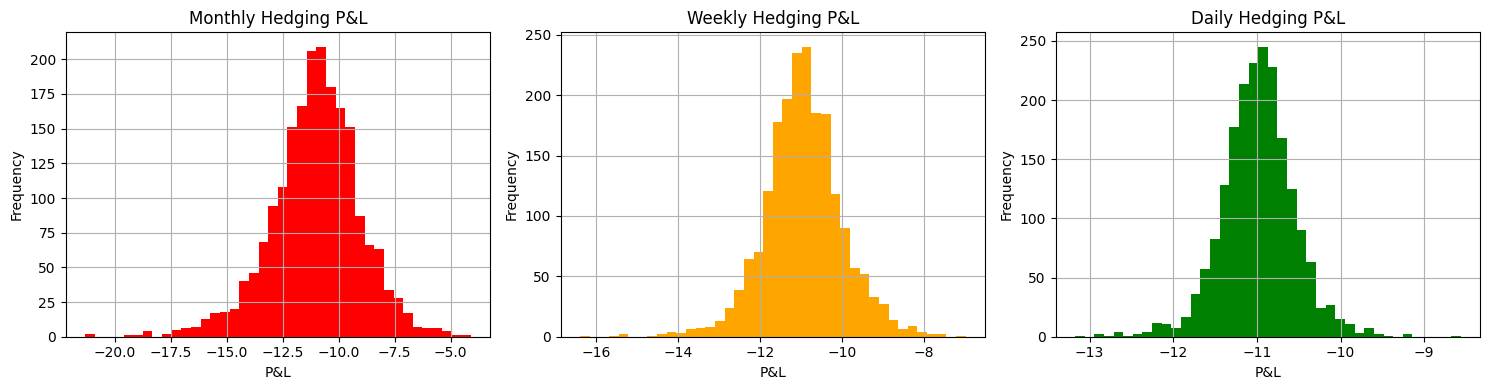

In [102]:
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.hist(pnl_m, bins=40, color="red")
plt.title("Monthly Hedging P&L")
plt.xlabel("P&L")
plt.ylabel("Frequency")
plt.grid(True)

plt.subplot(1,3,2)
plt.hist(pnl_w, bins=40, color="orange")
plt.title("Weekly Hedging P&L")
plt.xlabel("P&L")
plt.ylabel("Frequency")
plt.grid(True)

plt.subplot(1,3,3)
plt.hist(pnl_d, bins=40, color="green")
plt.title("Daily Hedging P&L")
plt.xlabel("P&L")
plt.ylabel("Frequency")
plt.grid(True)

plt.tight_layout()
plt.show()

All three histograms show the expected pattern:
the hedging error distribution becomes progressively tighter as the rebalancing frequency increases.

**Monthly hedging** exhibits very large dispersion (from –20 to –5), reflecting strong discretisation noise.

**Weekly hedging** already reduces variance significantly.

**Daily hedging** produces the tightest distribution.

However, a key observation from the numerical results is that all three hedging schemes produce a **negative mean P&L** (≈ –7.48, –8.61, –10.31 for monthly, weekly, daily respectively). 
This reflects the well-known **gamma cost of discrete hedging**:

- the option payoff is **convex**,
- delta hedging is **linear**,
- therefore any finite rebalancing frequency leads to a **systematic replication shortfall**.

Even daily hedging leaves: non-zero variance, a persistent negative bias due to convexity, residual discretisation and gamma exposure.

This illustrates a fundamental fact of quantitative finance: perfect replication under Black–Scholes is a continuous-time idealisation. In reality, hedging is discrete : replication is imperfect : residual risk and structural P&L bias remain. This is why practical pricing must incorporate:

- volatility modelling,
- transaction cost models,
- gamma/vega risk charges,
- and robust hedging approaches.
